### The code for replicating the results and figures from the paper:
## "COVID-19 amplifies gender disparities in research"
by Goran Murić, Kristina Lerman and Emilio Ferrara

In [1]:
### Import all packages
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import math
import statsmodels.api as sm
from collections import OrderedDict 
from scipy import stats
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

In C:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


### Define all necessary functions

In [2]:
colors={'lightgrey':'#bcc4cd',
        'darkgrey':'#566573',
       'myorange':'#e95c25',
       'myblue':'#4392f1',
       'mygreen':'#00a878'}

def f_fraction(x):
    v = x['gender'].value_counts()
    if v.sum()<10:
        return(np.nan)
    try: 
        f = v['female']/(v['male']+v['female'])
    except:
        f = np.nan
    return(f)

def m_fraction(x):
    v = x['gender'].value_counts()
    if v.sum()<10:
        return(np.nan)
    try: 
        f = v['male']/(v['male']+v['female'])
    except:
        f = np.nan
    return(f)

def f_number(x):
    v = x['gender'].value_counts()
    try: 
        f = v['female']
        return(f)
    except:
        return(0)

def m_number(x):
    v = x['gender'].value_counts()
    try: 
        f = v['male']
        return(f)
    except:
        return(0)

def n_papers(x):
    v = x.drop_duplicates(subset='paper_id')
    return(len(v))



def predicted_frac(df,freq,split_date,gt_max_date, covid='all'):
    g = df.groupby(pd.Grouper(key='date',freq=freq))
    n = g.apply(f_fraction)[:gt_max_date]
    if len(n.dropna())<3:
        return(np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan)
    n = n.interpolate(limit_direction='both', limit_area='inside', limit=2)
    periods = len(n[split_date:gt_max_date])-1
    Y_pre = n.loc[:split_date]
    X_pre = range(0,len(Y_pre))
    X_pre = sm.add_constant(X_pre)
    results_pre = sm.OLS(Y_pre,X_pre).fit()
    if periods==1:
        periods=2
    x1n = np.linspace(X_pre.max()+1,X_pre.max()+periods, periods)
    Xnew = sm.add_constant(x1n)
    predictions = results_pre.get_prediction(Xnew).summary_frame(alpha=0.1)
    expected = np.mean(predictions['mean'])
    pred_err = np.mean(predictions['mean_se'])
    
    p_value = results_pre.pvalues['x1']
    r2 = results_pre.rsquared
    coef = results_pre.params['x1']
    
    if covid==True:
        g2 = df[df['is_covid']==True].groupby(pd.Grouper(key='date',freq=freq))
        n_cov = g2.apply(f_fraction)[:gt_max_date]
        if len(n_cov.loc[split_date:gt_max_date].dropna())<7:
            return(expected, np.nan, pred_err, np.nan, np.nan, np.nan, np.nan)

    if covid==False:
        g2 = df[df['is_covid']==False].groupby(pd.Grouper(key='date',freq=freq))
        n_cov = g2.apply(f_fraction)[:gt_max_date]
        if len(n_cov.loc[split_date:gt_max_date].dropna())<7:
            return(expected, np.nan, pred_err, np.nan, np.nan, np.nan, np.nan)
    
    if covid=='all':
        real = np.mean(n.loc[split_date:gt_max_date])
        real_err = np.std(n.loc[split_date:gt_max_date])/len(n.loc[split_date:gt_max_date])**(1/2)
    else:
        real = np.mean(n_cov.loc[split_date:gt_max_date])
        real_err = np.std(n_cov.loc[split_date:gt_max_date])/len(n_cov.loc[split_date:gt_max_date])**(1/2)
    
    #err = (expected - np.mean(predictions['obs_ci_lower'])) + np.std(n.loc[split_date:gt_max_date])/len(n.loc[split_date:gt_max_date])**(1/2)
    #pred_err = expected - np.mean(predictions['mean_ci_lower'])
    return(expected, real, pred_err, real_err, p_value, r2, coef)

def gender_diff_frac(df,freq,split_date,gt_max_date,covid):
    expected, real, pred_err, real_err, p_value, r2, coef =  predicted_frac(df,freq,split_date,gt_max_date, covid)
    return(expected, real, pred_err, real_err, p_value, r2, coef)

def get_inc(df,freq,split_date,gt_max_date,gender, num_papers=False):
    g = df.groupby(pd.Grouper(key='date',freq=freq))
    
    if num_papers==True:
        fractions = g.apply(n_papers)[:gt_max_date]    
    else:
        if gender=='f':
            fractions = g.apply(f_number)[:gt_max_date]
        if gender=='m':
            fractions = g.apply(m_number)[:gt_max_date]
        if gender=='all':
            fractions_f = g.apply(f_number)[:gt_max_date]
            fractions_m = g.apply(m_number)[:gt_max_date]
            fractions = fractions_f + fractions_m
    
    periods = len(fractions[split_date:gt_max_date])-1
    Y_pre = fractions.loc[:split_date]
    X_pre = range(0,len(Y_pre))
    X_pre = sm.add_constant(X_pre)
    results_pre = sm.OLS(Y_pre,X_pre).fit()
    x1n = np.linspace(X_pre.max(),X_pre.max()+periods, periods)
    Xnew = sm.add_constant(x1n)
    predictions = results_pre.get_prediction(Xnew).summary_frame(alpha=0.01)
    expected = np.sum(predictions['mean'])
    real = np.sum(fractions.loc[split_date:])
    real_err = np.std(fractions.loc[split_date:gt_max_date])/len(fractions.loc[split_date:gt_max_date])**(1/2)
    pred_err = np.sum(predictions['mean_se'])
    
    p_value = results_pre.pvalues['x1']
    r2 = results_pre.rsquared
    coef = results_pre.params['x1']
    return(expected, real, pred_err, real_err, p_value, r2, coef)

### Some general statistics

In [3]:
df = pd.read_csv('data\\standardized_data.csv', parse_dates = ['date'])
print('biorxiv papers: '+str(len(df[df['platform']=='biorXiv']['paper_id'].drop_duplicates())))
print('biorxiv authors: '+str(len(df[df['platform']=='biorXiv']['name'].drop_duplicates())))
print('start date: '+ str(df[df['platform']=='biorXiv']['date'].min()))
print('medrxiv papers: '+str(len(df[df['platform']=='medrXiv']['paper_id'].drop_duplicates())))
print('medrxiv authors: '+str(len(df[df['platform']=='medrXiv']['name'].drop_duplicates())))
print('start date: '+ str(df[df['platform']=='medrXiv']['date'].min()))
print('springer papers: '+str(len(df[df['platform']=='Springer']['paper_id'].drop_duplicates())))
print('springer authors: '+str(len(df[df['platform']=='Springer']['name'].drop_duplicates())))
print('start date: '+ str(df[df['platform']=='Springer']['date'].min()))
print('Total number of papers: '+str(df['paper_id'].nunique()))
print('Total number of authors: '+str(df['name'].nunique()))
print('Number of authors with gender probability score <0.8: '+str(len(df[df['probability']<0.8])/len(df)))

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning:

Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.



biorxiv papers: 43459
biorxiv authors: 232292
start date: 2019-01-01 00:00:00
medrxiv papers: 5080
medrxiv authors: 35882
start date: 2019-06-25 00:00:00
springer papers: 32348
springer authors: 210854
start date: 2019-01-01 00:00:00
Total number of papers: 80875
Total number of authors: 445633
Number of authors with gender probability score <0.8: 0.19701766564379367


In [4]:
df1 = df[df['probability']>=0.8]
print('Stats after removing authors with the ambiguous gender:')
print('biorxiv papers: '+str(len(df1[df1['platform']=='biorXiv']['paper_id'].drop_duplicates())))
print('biorxiv authors: '+str(len(df1[df1['platform']=='biorXiv']['name'].drop_duplicates())))
print('start date: '+ str(df1[df1['platform']=='biorXiv']['date'].min()))
print('medrxiv papers: '+str(len(df1[df1['platform']=='medrXiv']['paper_id'].drop_duplicates())))
print('medrxiv authors: '+str(len(df1[df1['platform']=='medrXiv']['name'].drop_duplicates())))
print('start date: '+ str(df1[df1['platform']=='medrXiv']['date'].min()))
print('springer papers: '+str(len(df1[df1['platform']=='Springer']['paper_id'].drop_duplicates())))
print('springer authors: '+str(len(df1[df1['platform']=='Springer']['name'].drop_duplicates())))
print('start date: '+ str(df1[df1['platform']=='Springer']['date'].min()))
print('Total number of papers: '+str(df1['paper_id'].nunique()))
print('Total number of authors: '+str(df1['name'].nunique()))
print('Males: '+str(len(df1[df1['gender']=='male'].drop_duplicates(subset='name'))))
print('Females: '+str(len(df1[df1['gender']=='female'].drop_duplicates(subset='name'))))

Stats after removing authors with the ambiguous gender:
biorxiv papers: 42417
biorxiv authors: 193080
start date: 2019-01-01 00:00:00
medrxiv papers: 4987
medrxiv authors: 29667
start date: 2019-06-25 00:00:00
springer papers: 31106
springer authors: 164380
start date: 2019-01-01 00:00:00
Total number of papers: 78499
Total number of authors: 361234
Males: 228449
Females: 132789


In [5]:
freq = 'W'
split_date = "2020-01-31"
gt_max_date = "2020-05-03"

df = pd.read_csv('data\\standardized_data.csv', parse_dates = ['date'])
# remove genders with probability < 0.6
df = df[df['probability']>=0.8]

# remove countries that do not appear in COVID period 
df = df[df['country_code'].isin(df[df['date']>=split_date]['country_code'].unique())]

#make a new dataset keeping only first authors
df1 = df[df['order']==1]

### Increase of number of authors

Text(1, 90000, 'Authors')

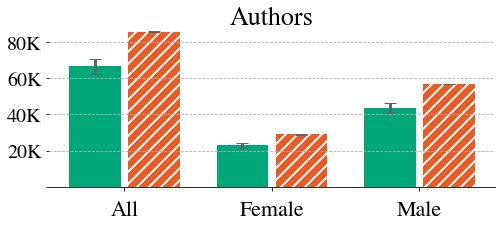

In [6]:
f = get_inc(df,freq,split_date,gt_max_date,'f', num_papers=False)
m = get_inc(df,freq,split_date,gt_max_date,'m', num_papers=False)
tot = get_inc(df,freq,split_date,gt_max_date,'all', num_papers=False)

v = {'All': {'expected':tot[0], 'real':tot[1], 'expected_err':tot[2], 'real_err':tot[3], 'p':tot[4], 'r2':tot[5], 'coef':tot[6]},
        'Female':{'expected':f[0], 'real':f[1], 'expected_err':f[2], 'real_err':f[3], 'p':f[4], 'r2':f[5], 'coef':f[6]},
        'Male':{'expected':m[0], 'real':m[1], 'expected_err':m[2], 'real_err':m[3], 'p':m[4], 'r2':m[5], 'coef':m[6]}
       }

mpl.rcParams['hatch.linewidth'] = 2
mpl.rcParams['hatch.color'] = 'white'
fig, ax = plt.subplots(1, figsize=(8, 3))

x = np.array(range(0,len(v.keys())))

expected = [v['expected'] for k,v in v.items()]
ax.bar(x-0.2,expected, width=0.35, 
          align = 'center', color=colors['mygreen'],label='Expected')

real = [v['real'] for k,v in v.items()]
ax.bar(x+0.2,real, width=0.35, 
          align = 'center', color=colors['myorange'], hatch="//", label='Observed')

expected_err = [v['expected_err'] for k,v in v.items()]
ax.errorbar(x-0.2, expected, yerr=expected_err, color='#566573', linewidth=3, ls='none',capsize=6)
real_err = [v['real_err'] for k,v in v.items()]
ax.errorbar(x+0.2, real, yerr=real_err, color='#566573', linewidth=3, ls='none',capsize=6)

ax.set_xticks(x)
ax.tick_params(axis='x', which='major', pad=10)
labels = ['All', 'Female', 'Male']
ax.set_xticklabels(labels, fontsize=22)
ax.yaxis.grid(True, which='major', linestyle='--')
ax.set_yticklabels([''] + [str(int(x/1000))+'K' for x in ax.get_yticks()][1:], size = 20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.text(1,90000,'Authors',horizontalalignment='center', fontsize=26)

In [7]:
print('% increase in number of authors')
for k, value in v.items():
    print(str(k)+': '+str((v[k]['real']-v[k]['expected'])*100/v[k]['expected'])+'%')

% increase in number of authors
All: 28.796177685080565%
Female: 26.62288424249775%
Male: 29.93062138262508%


### Increase of number of papers

Text(1.5, 14000, 'Papers')

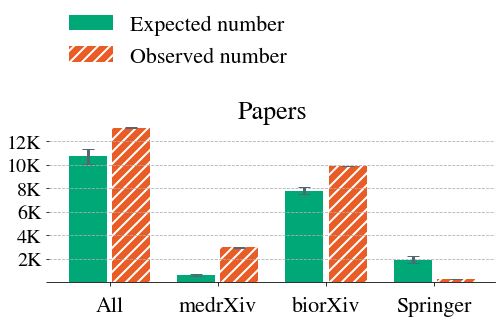

In [8]:
tot = get_inc(df,freq,split_date,gt_max_date,'f', num_papers=True)
med = get_inc(df[df['platform']=='medrXiv'],freq,split_date,gt_max_date,'f', num_papers=True)
bio = get_inc(df[df['platform']=='biorXiv'],freq,split_date,gt_max_date,'m', num_papers=True)
sp = get_inc(df[df['platform']=='Springer'],freq,split_date,gt_max_date,'all', num_papers=True)

v = {'All': {'expected':tot[0], 'real':tot[1], 'expected_err':tot[2], 'real_err':tot[3], 'p':tot[4], 'r2':tot[5], 'coef':tot[6]},
    'medrXiv': {'expected':med[0], 'real':med[1], 'expected_err':med[2], 'real_err':med[3], 'p':med[4], 'r2':med[5], 'coef':med[6]},
        'biorXiv':{'expected':bio[0], 'real':bio[1], 'expected_err':bio[2], 'real_err':bio[3], 'p':bio[4], 'r2':bio[5], 'coef':bio[6]},
        'Springer':{'expected':sp[0], 'real':sp[1], 'expected_err':sp[2], 'real_err':sp[3], 'p':sp[4], 'r2':sp[5], 'coef':sp[6]}
       }

mpl.rcParams['hatch.linewidth'] = 2
mpl.rcParams['hatch.color'] = 'white'
fig, ax = plt.subplots(1, figsize=(8, 3))

x = np.array(range(0,len(v.keys())))

expected = [v['expected'] for k,v in v.items()]
ax.bar(x-0.2,expected, width=0.35, 
          align = 'center', color=colors['mygreen'],label='Expected number')

real = [v['real'] for k,v in v.items()]
ax.bar(x+0.2,real, width=0.35, 
          align = 'center', color=colors['myorange'], hatch="//", label='Observed number')

expected_err = [v['expected_err'] for k,v in v.items()]
ax.errorbar(x-0.2, expected, yerr=expected_err, color='#566573', linewidth=3, ls='none',capsize=6)
real_err = [v['real_err'] for k,v in v.items()]
ax.errorbar(x+0.2, real, yerr=real_err, color='#566573', linewidth=3, ls='none',capsize=6)

ax.set_xticks(x)
ax.tick_params(axis='x', which='major', pad=10)
labels = v.keys()

ax.set_xticklabels(labels, fontsize=22)

ax.yaxis.grid(True, which='major', linestyle='--')
ax.set_yticklabels([''] + [str(int(x/1000))+'K' for x in ax.get_yticks()][1:], size = 20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
#ax.set_ylabel('Papers', fontsize=24, labelpad=5)
ax.legend(ncol=1, fontsize=22, frameon=False, loc='lower left', bbox_to_anchor=(0, 1.2))
ax.text(1.5,14000,'Papers',horizontalalignment='center', fontsize=26)

In [9]:
print('% increase in number of papers')
for k, value in v.items():
    print(str(k)+': '+str((v[k]['real']-v[k]['expected'])*100/v[k]['expected'])+'%')

% increase in number of papers
All: 22.59129418836916%
medrXiv: 363.8779707948013%
biorXiv: 26.8796464597577%
Springer: -84.595564024728%


### Gender differences in general across platforms

In [10]:
types = ['First','Any']
all_ = {}
for t in types:
    if t=='First':
        d = df1
    if t=='Any':
        d = df
        
    c = gender_diff_frac(d,freq,split_date,gt_max_date, covid='all')
    cd = gender_diff_frac(d,freq,split_date,gt_max_date, covid=True)
    cn = gender_diff_frac(d,freq,split_date,gt_max_date, covid=False)
    
    all_[t] = {'All':{'expected':c[0],'real':c[1],'expected_err':c[2], 'real_err':c[3], 'p_value':c[4], 'r2':c[5], 'coef':c[6]},
               'COVID':{'expected':cd[0],'real':cd[1],'expected_err':cd[2], 'real_err':cd[3], 'p_value':cd[4], 'r2':cd[5], 'coef':cd[6]},
               'nonCOVID':{'expected':cn[0],'real':cn[1],'expected_err':cn[2], 'real_err':cn[3], 'p_value':cn[4], 'r2':cn[5], 'coef':cn[6]}}

medrxiv = {}
for t in types:
    if t=='First':
        d = df1[df1['platform']=='medrXiv']
    if t=='Any':
        d = df[df['platform']=='medrXiv']
        
    c = gender_diff_frac(d,freq,split_date,gt_max_date, covid='all')
    cd = gender_diff_frac(d,freq,split_date,gt_max_date, covid=True)
    cn = gender_diff_frac(d,freq,split_date,gt_max_date, covid=False)
    
    medrxiv[t] = {'All':{'expected':c[0],'real':c[1],'expected_err':c[2], 'real_err':c[3], 'p_value':c[4], 'r2':c[5], 'coef':c[6]},
               'COVID':{'expected':cd[0],'real':cd[1],'expected_err':cd[2], 'real_err':cd[3], 'p_value':cd[4], 'r2':cd[5], 'coef':cd[6]},
               'nonCOVID':{'expected':cn[0],'real':cn[1],'expected_err':cn[2], 'real_err':cn[3], 'p_value':cn[4], 'r2':cn[5], 'coef':cn[6]}}
    
biorxiv = {}
for t in types:
    if t=='First':
        d = df1[df1['platform']=='biorXiv']
    if t=='Any':
        d = df[df['platform']=='biorXiv']
        
    c = gender_diff_frac(d,freq,split_date,gt_max_date, covid='all')
    cd = gender_diff_frac(d,freq,split_date,gt_max_date, covid=True)
    cn = gender_diff_frac(d,freq,split_date,gt_max_date, covid=False)
    
    biorxiv[t] = {'All':{'expected':c[0],'real':c[1],'expected_err':c[2], 'real_err':c[3], 'p_value':c[4], 'r2':c[5], 'coef':c[6]},
               'COVID':{'expected':cd[0],'real':cd[1],'expected_err':cd[2], 'real_err':cd[3], 'p_value':cd[4], 'r2':cd[5], 'coef':cd[6]},
               'nonCOVID':{'expected':cn[0],'real':cn[1],'expected_err':cn[2], 'real_err':cn[3], 'p_value':cn[4], 'r2':cn[5], 'coef':cn[6]}}
    
springer = {}
for t in types:
    if t=='First':
        d = df1[df1['platform']=='Springer']
    if t=='Any':
        d = df[df['platform']=='Springer']
        
    c = gender_diff_frac(d,freq,split_date,gt_max_date, covid='all')
    cd = gender_diff_frac(d,freq,split_date,gt_max_date, covid=True)
    cn = gender_diff_frac(d,freq,split_date,gt_max_date, covid=False)
    
    springer[t] = {'All':{'expected':c[0],'real':c[1],'expected_err':c[2], 'real_err':c[3], 'p_value':c[4], 'r2':c[5], 'coef':c[6]},
               'COVID':{'expected':cd[0],'real':cd[1],'expected_err':cd[2], 'real_err':cd[3], 'p_value':cd[4], 'r2':cd[5], 'coef':cd[6]},
               'nonCOVID':{'expected':cn[0],'real':cn[1],'expected_err':cn[2], 'real_err':cn[3], 'p_value':cn[4], 'r2':cn[5], 'coef':cn[6]}}
    
    everything = {'biorXiv':biorxiv, 'medrXiv':medrxiv, 'Springer-Nature':springer}

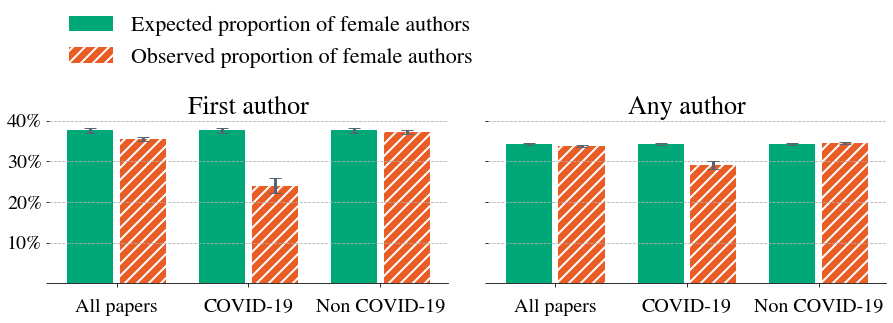

In [11]:
plot_data = {'All publishers':all_}

mpl.rcParams['hatch.linewidth'] = 2
mpl.rcParams['hatch.color'] = 'white'
fig, ax = plt.subplots(len(plot_data), 2, figsize=(15, len(plot_data)*3), sharey=True)

j = 0
for c, v in all_.items():

    x = np.array(range(0,len(v.keys())))

    expected = [v['expected']*100 for k,v in v.items()]
    ax[j].bar(x-0.2,expected, width=0.35, 
              align = 'center', color=colors['mygreen'],label='Expected proportion of female authors')

    real = [v['real']*100 for k,v in v.items()]
    ax[j].bar(x+0.2,real, width=0.35, 
              align = 'center', color=colors['myorange'], hatch="//", label='Observed proportion of female authors')

    expected_err = [v['expected_err']*100 for k,v in v.items()]
    ax[j].errorbar(x-0.2, expected, yerr=expected_err, color='#566573', linewidth=3, ls='none',capsize=6)
    real_err = [v['real_err']*100 for k,v in v.items()]
    ax[j].errorbar(x+0.2, real, yerr=real_err, color='#566573', linewidth=3, ls='none',capsize=6)

    ax[j].set_xticks(x)
    ax[j].tick_params(axis='x', which='major', pad=12)
    labels = ['All papers', 'COVID-19', 'Non COVID-19']

    ax[j].set_xticklabels(labels, fontsize=20)
    ax[j].set_title(c+' author', fontsize=26)

    ax[j].yaxis.grid(True, which='major', linestyle='--')
    ax[j].spines['top'].set_visible(False)
    ax[j].spines['right'].set_visible(False)
    ax[j].spines['left'].set_visible(False)
    if j == 0:

        ax[j].legend(ncol=1, fontsize=22, frameon=False, loc='lower left', bbox_to_anchor=(0, 1.2))
        ax[j].set_yticklabels([''] + [str(int(x))+'%' for x in ax[j].get_yticks()][1:], size = 20)

    j+=1
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

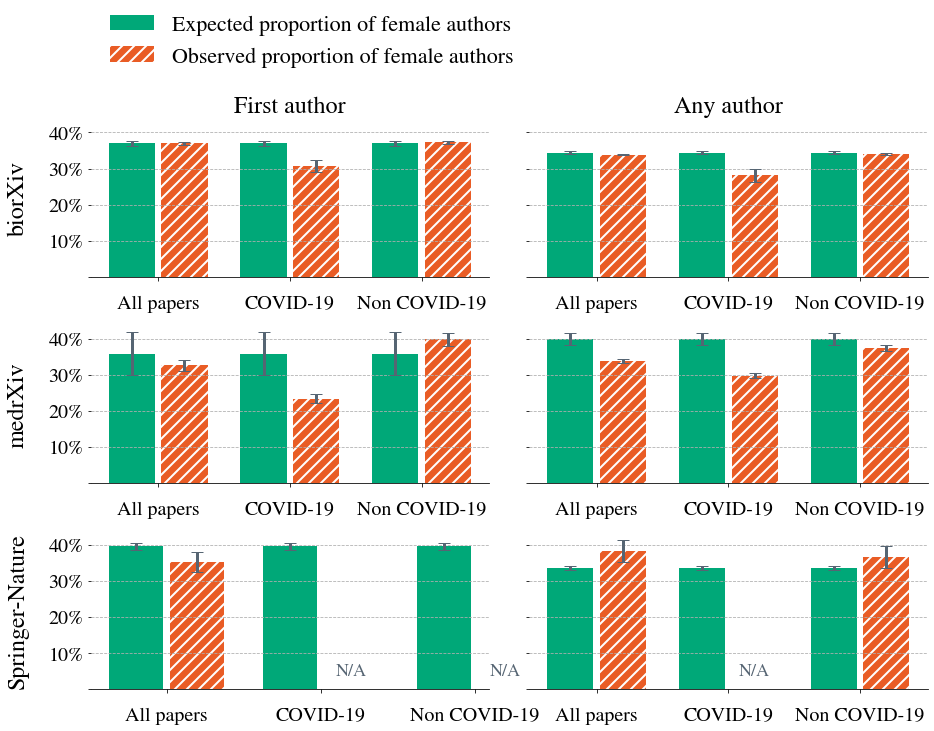

In [12]:
plot_data = everything

mpl.rcParams['hatch.linewidth'] = 2
mpl.rcParams['hatch.color'] = 'white'
fig, ax = plt.subplots(len(plot_data), 2, figsize=(15, len(plot_data)*3.5), sharey=True)

i = 0
for k, value in everything.items():
    j = 0
    for c, v in value.items():

        x = np.array(range(0,len(v.keys())))

        expected = [v['expected']*100 for k,v in v.items()]
        ax[i,j].bar(x-0.2,expected, width=0.35, 
                  align = 'center', color=colors['mygreen'],label='Expected proportion of female authors')

        real = [v['real']*100 for k,v in v.items()]
        ax[i,j].bar(x+0.2,real, width=0.35, 
                  align = 'center', color=colors['myorange'], hatch="//", label='Observed proportion of female authors')
        for loc,value in zip(x,real):
            if math.isnan(value):
                ax[i,j].text(loc+0.2,4,'N/A',horizontalalignment='center', fontsize=18, color=colors['darkgrey'])

        expected_err = [v['expected_err']*100 for k,v in v.items()]
        ax[i,j].errorbar(x-0.2, expected, yerr=expected_err, color='#566573', linewidth=3, ls='none',capsize=6)
        real_err = [v['real_err']*100 for k,v in v.items()]
        ax[i,j].errorbar(x+0.2, real, yerr=real_err, color='#566573', linewidth=3, ls='none',capsize=6)

        
        ax[i,j].set_xticks(x)
        ax[i,j].tick_params(axis='x', which='major', pad=14)
        labels = ['All papers', 'COVID-19', 'Non COVID-19']
        
        ax[i,j].set_xticklabels(labels, fontsize=20)
        if i==0:
            ax[i,j].set_title(c+' author', fontsize=24)
        
        ax[i,j].yaxis.grid(True, which='major', linestyle='--')
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].spines['right'].set_visible(False)
        ax[i,j].spines['left'].set_visible(False)
        if j == 0:
            ax[i,j].set_ylabel(k, fontsize=24, labelpad=20)
            ax[i,j].set_yticklabels([''] + [str(int(x))+'%' for x in ax[i,j].get_yticks()][1:], size = 20)
            if i == 0:
                ax[i,j].legend(ncol=1, fontsize=22, frameon=False, loc='lower left', bbox_to_anchor=(0, 1.2))
            
        j+=1
    i+=1
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

### Gender differences across countries

In [13]:
countries_data = pd.read_csv('data\\countries.csv')
countries_data['Name'] = countries_data['Name'].astype('str')
countries_data['Name'] = countries_data['Name'].str.title()
countries_data['Name'] = countries_data['Name'].str.replace(', Republic Of', '')
countries_data = countries_data.set_index('Code')
cc_map = countries_data['Name'].to_dict()

In [39]:
n=20
cc = df[df['country_code']!=np.nan]
#cc.groupby('country_code')['name'].count()
#big = cc.groupby('country_code')['name'].count()[cc.groupby('country_code')['name'].count()>n].index.values
big = cc.groupby('country_code')['name'].count().sort_values(ascending=False).iloc[0:n].index
cc = cc[cc['country_code'].isin(big)]

#cc['country_code'] = cc['country_code'].replace(cc_map)

countries_all = {}
countries_covid = {}
countries_noncovid = {}
G = cc.groupby('country_code')
for name, group in G:
    c = gender_diff_frac(group,freq,split_date,gt_max_date, covid='all')
    countries_all[name]= {'value':((c[1]-c[0])/c[0])*100,'err':((c[2]+c[3])/c[0])*100, 'raw':c}

    cd = gender_diff_frac(group,freq,split_date,gt_max_date, covid=True)
    countries_covid[name]= {'value':((cd[1]-cd[0])/cd[0])*100,'err':((cd[2]+cd[3])/cd[0])*100, 'raw':cd}
    
    cn = gender_diff_frac(group,freq,split_date,gt_max_date, covid=False)
    countries_noncovid[name]= {'value':((cn[1]-cn[0])/cn[0])*100,'err':((cn[2]+cn[3])/cn[0])*100, 'raw':cn}
    
data = {'All papers': countries_all, 'COVID-19': countries_covid, 'Non COVID-19': countries_noncovid}
geo_data = data

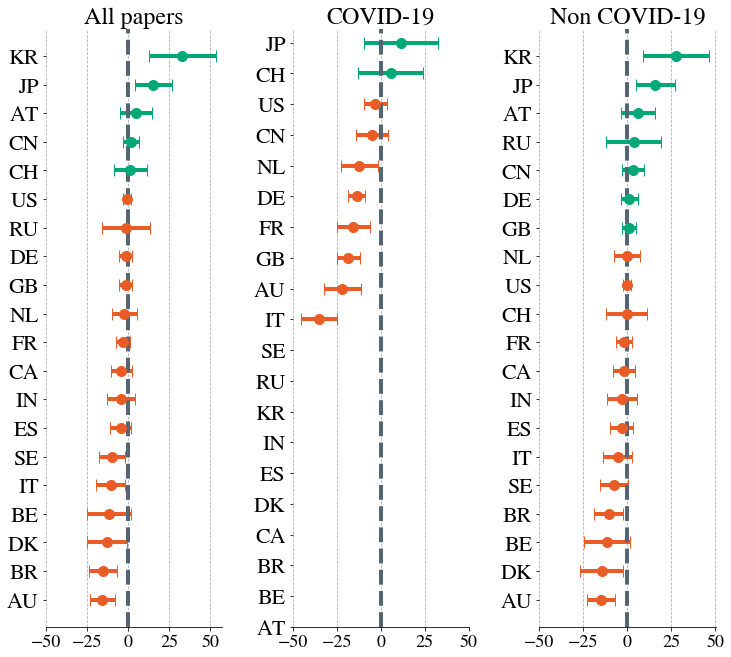

In [54]:
fig, ax = plt.subplots(1,3, figsize=(12, 11))
i=0
for name, d in data.items():
    countries_sort = OrderedDict(sorted(d.items(), key=lambda x: float('-inf') if math.isnan(x[1]['value']) else x[1]['value'], reverse=False))
    x = [v['value'] for v in countries_sort.values()]
    xerr = [v['err'] for v in countries_sort.values()]
    cols = [colors['myorange'] if v < 0 else colors['mygreen'] for v in x]
    
    y = range(0,len(countries_sort))
    for val, y_loc, err, col in zip(x,y,xerr,cols):
        ax[i].errorbar(val, y_loc, xerr=err, fmt='o', markersize=10, capsize=6, linewidth=4, color=col)
        
    ax[i].set_yticks(range(0,len(countries_sort)))
    labels = countries_sort.keys()
    ax[i].set_yticklabels(labels, fontsize=22)
    ax[i].xaxis.grid(True, which='major', linestyle='--')
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    #ax[i].set_xlim(left=-70, right=70)
    ax[i].set_title(name, fontsize=24)
    ax[i].set_xticks([-50,-25,0,25,50], minor=False)
    ax[i].tick_params(axis='x', which='major', labelsize=18)
    ax[i].axvline(x=0, linewidth=4, linestyle='--', color=colors['darkgrey'])
    i+=1
    
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)

### GDP analysis

In [18]:
covid_data = pd.read_csv('data\\owid-covid-data.csv')#, usecols=['location','total_cases_per_million', 'date'])
covid_data = covid_data[covid_data['date']==gt_max_date].drop(columns=['date'])
covid_data['location'] = covid_data['location'].astype('str').str.lower()

In [19]:
countries_data = pd.read_csv('..\\data\\affiliations\\countries.csv')
countries_data['Name'] = countries_data['Name'].astype('str')
countries_data['Name'] = countries_data['Name'].replace('korea, republic of', 'south korea')
countries_data = countries_data.set_index('Name')
covid_data = covid_data.join(countries_data, on='location')
covid_data['location'] = covid_data['location'].str.title()

In [20]:
asia = ['Japan', 'South Korea', 'China', 'India']

In [21]:
cc = df[df['country_code']!=np.nan]
cc = cc[(cc['country_code'].isin(big))&(cc['date']<=split_date)]
g = cc.groupby('country_code')

d = g.apply(f_fraction).to_frame().rename(columns={0:'frac_before'})
d2 = pd.DataFrame.from_dict(data['All papers'],orient='index').rename(columns={'value':'drop'})[['drop']]
cd = covid_data[covid_data['Code'].isin(d.index)]
cd = cd.join(d, on='Code').join(d2, on='Code')
cd['region'] = ['Asia' if x in asia else 'Europe and Americas' for x in cd['location']]
cd = cd[['location','gdp_per_capita','frac_before','drop','region']]
# replace South Korea with S. Korea
cd['location'] = cd['location'].str.replace('South Korea', 'S.Korea')

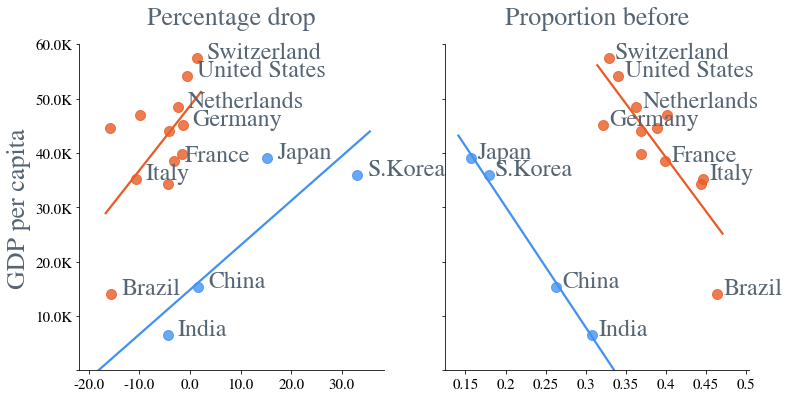

In [22]:
fig, ax = plt.subplots(1,2, figsize=(12, 6), sharey=True)
regions = ['Europe and Americas', 'Asia']
cols = [colors['myorange'], colors['myblue']]
for i in range(0,2):
    sns.regplot(x="drop", y="gdp_per_capita", data=cd[cd['region']==regions[i]], 
                ax=ax[0], ci=0, color=cols[i], label=regions[i], scatter_kws={"s": 100})
    sns.regplot(x="frac_before", y="gdp_per_capita", data=cd[cd['region']==regions[i]], 
                ax=ax[1], ci=0, color = cols[i], label = regions[i],scatter_kws={"s": 100})

forbid_names = ['Canada','United Kingdom','Sweden','Australia','Spain']
for i in range(0,2):

    ax[i].set_xlabel('')
    ax[i].set_ylim(0,60000)
    ax[i].set_yticklabels([''] + [str(round(x/1000,0))+'K' for x in ax[i].get_yticks()][1:], size = 15)
    ax[i].legend(ncol=1, fontsize=22, frameon=False, loc='upper left', bbox_to_anchor=(0.01, 1))
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    if i == 0:
        ax[i].set_ylabel("GDP per capita", fontsize=26, color=colors['darkgrey'])
        ax[i].set_title("Percentage drop", fontsize=26, color=colors['darkgrey'], pad=20)
        ax[i].set_xticklabels([str(round(x,2)) for x in ax[i].get_xticks()], size = 15)
        for j, txt in enumerate(cd['location']):
            if txt not in forbid_names:
                ax[i].annotate(txt, (cd['drop'].iloc[j]+2, cd['gdp_per_capita'].iloc[j]),
                                 fontsize=24, horizontalalignment='left', color=colors['darkgrey'])
    if i == 1:
        ax[i].set_ylabel('')
        ax[i].set_title("Proportion before", fontsize=26, color=colors['darkgrey'], pad=20)
        ax[i].set_xticklabels([str(round(x,2)) for x in ax[i].get_xticks()], size = 15)
        for j, txt in enumerate(cd['location']):
            if txt not in forbid_names:
                ax[i].annotate(txt, (cd['frac_before'].iloc[j]+0.008, cd['gdp_per_capita'].iloc[j]),
                                 fontsize=24, horizontalalignment='left', color=colors['darkgrey'])
    ax[i].get_legend().remove()

### World map

In [26]:
cc = df[df['country_code']!=np.nan]
countries_all = {}
countries_covid = {}
countries_noncovid = {}
G = cc.groupby('country_code')
for name, group in G:
    c = gender_diff_frac(group,'W',split_date,gt_max_date, covid='all')
    countries_all[name]= {'value':((c[1]-c[0])/c[0])*100,'err':((c[2]+c[3])/c[0])*100, 'raw':c}

C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning:

invalid value encountered in greater

C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning:

invalid value encountered in less

C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning:

invalid value encountered in less_equal



In [27]:
d2 = pd.DataFrame.from_dict(countries_all,orient='index').rename(columns={'value':'drop'})[['drop']]
cd = covid_data.join(d2, on='Code')
cd = cd[~cd['drop'].isna()]

In [28]:
data=go.Choropleth(
    locations = cd['iso_code'],
    z = cd['drop'],
    zmid=0,
    
    #text = df['COUNTRY'],
    colorscale = px.colors.diverging.RdBu,
    autocolorscale=False,
    reversescale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_ticksuffix = '%',
    #colorbar_title = '',
    colorbar=dict(thickness=30,
                  len=0.65,
                           ticklen=0, tickcolor='black',
                           tickfont=dict(size=22, color='grey'))
)

layout = dict(
    margin={'l': 0, 'r': 0, 't': 20, 'b': 0},
    geo = dict(
        landcolor = 'lightgray',
        showland = True,
        showcountries = False,
        countrycolor = 'gray',
        countrywidth = 0.5,
        showframe=False,
        projection = dict(
            type = 'equirectangular'
        )
    )
)

fig = go.Figure(data, layout = layout)

fig.show()